In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [1]:
#Constant values
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

## Data loading 

In [3]:
# Importing the data through image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names   #Printing the differnet types of diseases
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)       #It is showing 68 as the length --> it represents the batch 68*32 = 2176 images

68

## Visualising the images

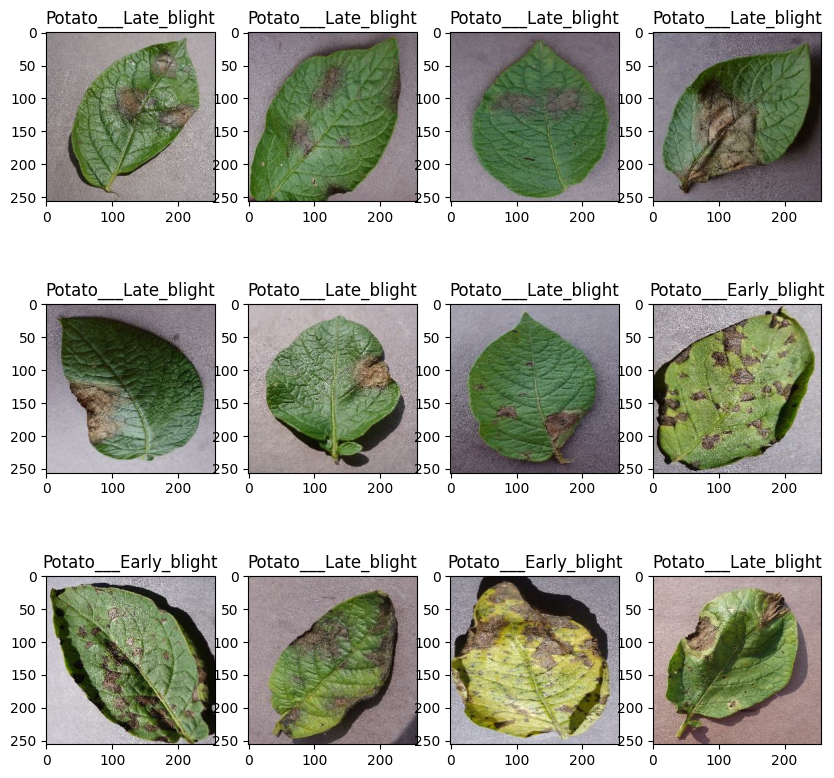

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        #print(image_batch[0].numpy())
        #print(label_batch.numpy())

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10%test

In [8]:
len(dataset)

68

## Data Splitting

In [9]:
train_size = 0.8
len(dataset) *train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)* val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
# The operations performed above can be generalized through the below given function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1 , test_split=0.1, shuffle_size=1000):
    ds_size = len(ds)

    train_size = int(train_split * ds_size)        # train_size = 0.8
    val_size = int(val_split * ds_size)            # val_size = 0.1

    train_ds = ds.take(train_size)                 # takes 54 batches

    val_ds = ds.skip(train_size).take(val_size)    # takes 6 batches
    test_ds = ds.skip(train_size).skip(val_size)   # takes 8 batches

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


## Data Preprocessing

In [18]:
# Cache Transformation : This will save some operations (like file opening and data reading) from being executed during each epoch
# Prefetching overlaps the preprocessing and model execution of a training step
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# Increasing the diversity of the training data by some image transformations like : contrast, zoom, horizontal/vertical flip, rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25


54/54 [==============================] - 208s 4s/step - loss: 0.8928 - accuracy: 0.4977 - val_loss: 0.8304 - val_accuracy: 0.5365
Epoch 2/25
54/54 [==============================] - 185s 3s/step - loss: 0.5356 - accuracy: 0.7645 - val_loss: 0.4493 - val_accuracy: 0.8177
Epoch 3/25
54/54 [==============================] - 186s 3s/step - loss: 0.3902 - accuracy: 0.8478 - val_loss: 0.3108 - val_accuracy: 0.8802
Epoch 4/25
54/54 [==============================] - 182s 3s/step - loss: 0.2689 - accuracy: 0.8860 - val_loss: 0.2924 - val_accuracy: 0.9115
Epoch 5/25
54/54 [==============================] - 179s 3s/step - loss: 0.2355 - accuracy: 0.9045 - val_loss: 0.2810 - val_accuracy: 0.9010
Epoch 6/25
54/54 [==============================] - 185s 3s/step - loss: 0.2005 - accuracy: 0.9225 - val_loss: 0.2856 - val_accuracy: 0.9062
Epoch 7/25
54/54 [==============================] - 170s 3s/step - loss: 0.1704 - accuracy: 0.9381 - val_loss: 0.3413 - val_accuracy: 0.8542
Epoch 8/25


In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 183ms/step - loss: 0.1248 - accuracy: 0.9655


In [26]:
scores

[0.12476399540901184, 0.9655172228813171]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Training and validation graphs

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

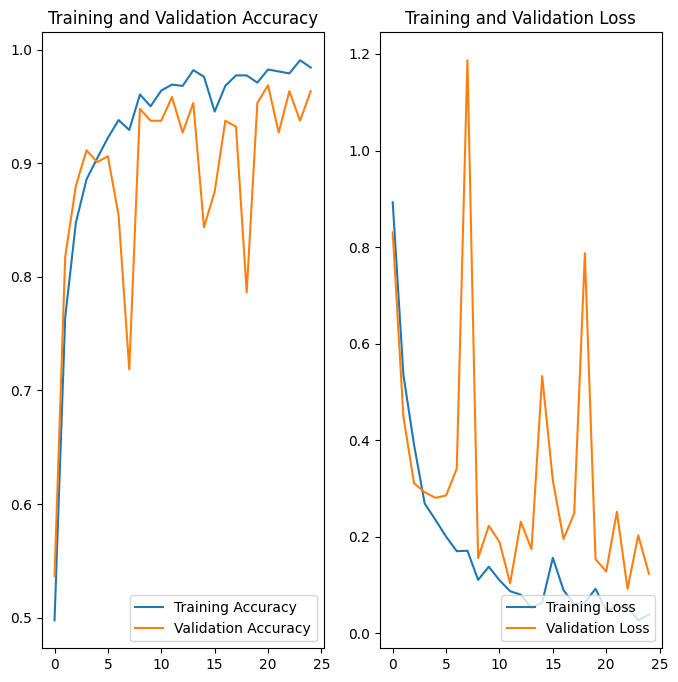

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

## Testing 

first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 271ms/step
Predicted Label:  Potato___Early_blight


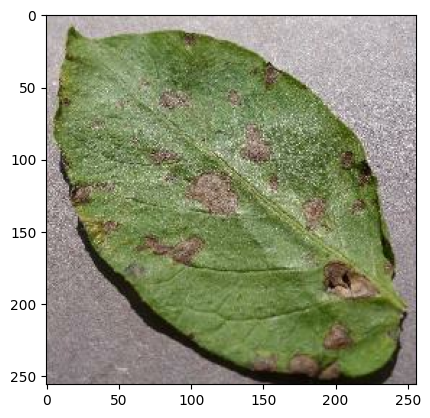

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model ,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


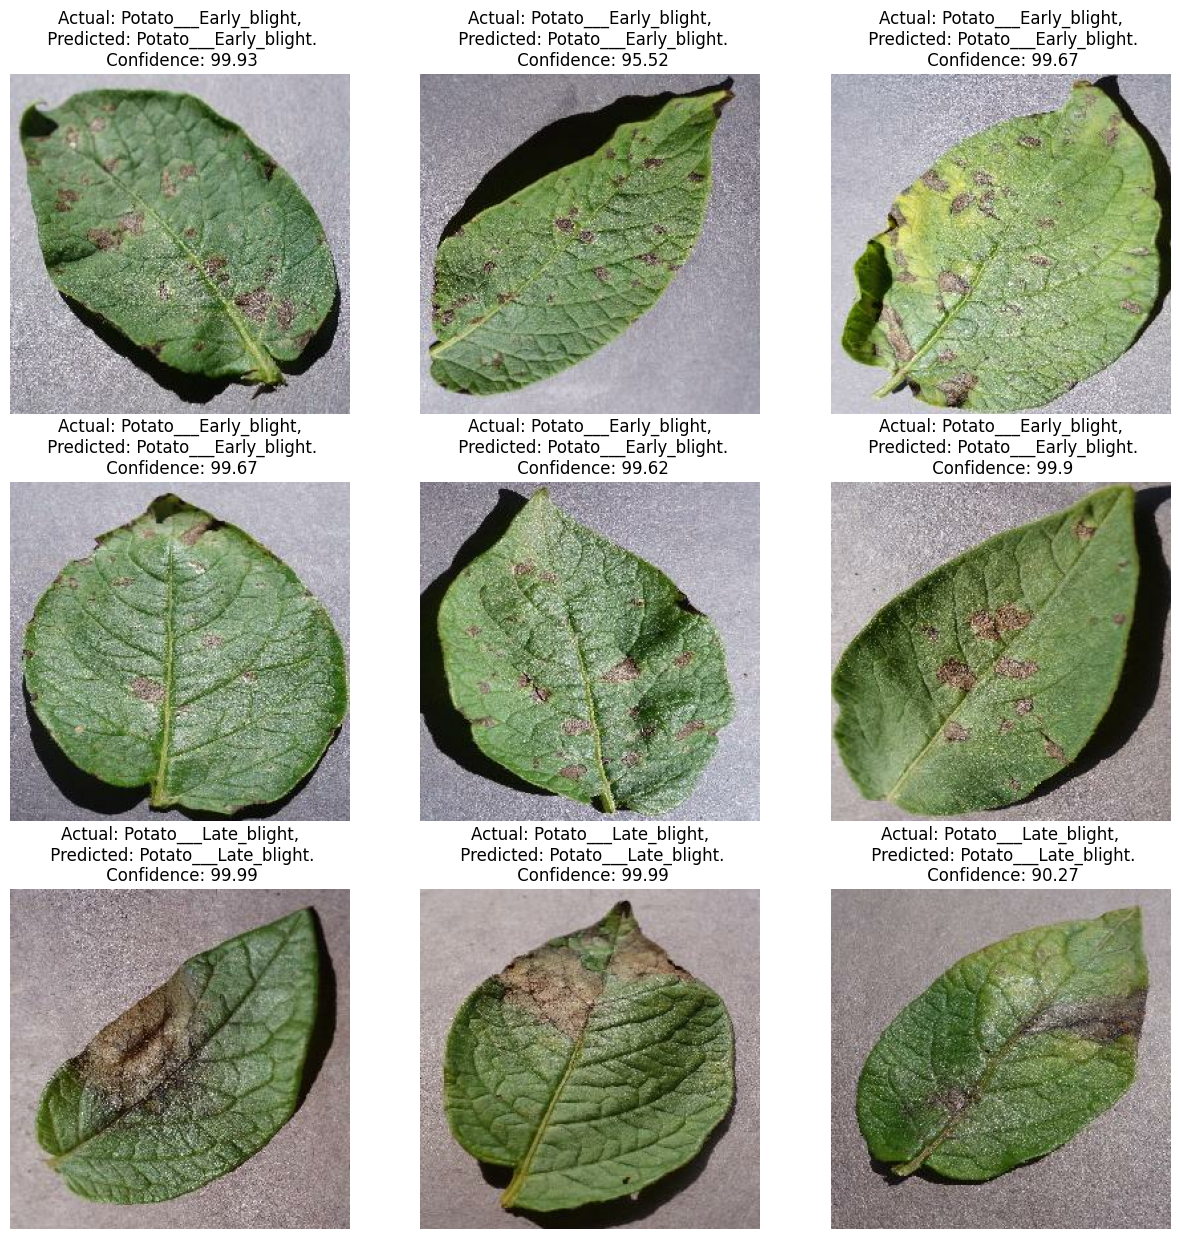

In [48]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis("off")